In [1]:
# Import statements
# Declare Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import os
import pickle
from textwrap import wrap
import operator
import au_census_analysis_functions as cnss_func
import geopandas as gpd
import plotly.express as px
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.colors import TwoSlopeNorm

# Set a variable for current notebook's path for various loading/saving mechanisms
nb_path = os.getcwd()

In [2]:
# Read SHP file
SA2_gdf = gpd.read_file('{}/Shapefiles/SA2/SA2_2021_AUST_GDA2020.shp'.format(nb_path))    # Load the data using Geopandas

In [3]:
# Test the import worked
SA2_gdf.rename(columns={'SA2_CODE21' : 'Code'}) #this renaming isn't working?
SA2_gdf.head()

,SA2_CODE21,SA2_NAME21,CHG_FLAG21,CHG_LBL21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,GCC_CODE21,GCC_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
0,101021007,Braidwood,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,3418.3525,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.58424 -35.44426, 149.58444 -35.4..."
1,101021008,Karabar,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,6.9825,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.21899 -35.36738, 149.21800 -35.3..."
2,101021009,Queanbeyan,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,4.7620,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.21326 -35.34325, 149.21619 -35.3..."
3,101021010,Queanbeyan - East,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,13.0032,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.24034 -35.34781, 149.24024 -35.3..."
4,101021012,Queanbeyan West - Jerrabomberra,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,13.6748,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.19572 -35.36126, 149.19970 -35.3..."


In [4]:
# Import the G01 table which has basic population data for 2021 and 2016 
df_2021 = cnss_func.load_census_csv(table_list=['G01'],statistical_area_code='SA2', year=2021).iloc[:,[0,3]]
df_2021.columns=['Code','TotalPop']

df_2016 = cnss_func.load_census_csv(table_list=['G01'],statistical_area_code='SA2', year=2016).iloc[:,[0,3]]
df_2016.columns=['Code','TotalPop']
df_2021.head()

,Code,TotalPop
0,101021007,4343
1,101021008,8517
2,101021009,11342
3,101021010,5085
4,101021012,12744


In [6]:
# merge the dataframes and create a "Population change" feature
df_pops = df_2016.merge(df_2021,left_on='Code', right_on='Code')
df_pops.columns=['Code','2016_Population','2021_Population']
df_pops['Change_2016_to_2021'] = (df_pops['2021_Population']-df_pops['2016_Population'])

# create change % feature
df_pops['Change_pc'] = ((df_pops['2021_Population']/df_pops['2016_Population'])-1)

df_pops.head()

,Code,2016_Population,2021_Population,Change_2016_to_2021,Change_pc
0,101021007,3872,4343,471,0.121643
1,101021008,8247,8517,270,0.032739
2,101021009,10842,11342,500,0.046117
3,101021010,4786,5085,299,0.062474
4,101021012,12643,12744,101,0.007989


In [8]:
# convert code to Str for merging with geopandas table
df_pops['Code'] = df_pops['Code'].astype('str')

# merge
df_merged = pd.merge(SA2_gdf[['SA2_CODE21','SA2_NAME21','geometry']], 
                     df_pops[['Code','Change_2016_to_2021', 'Change_pc']],
                     left_on='SA2_CODE21',
                     right_on='Code')
df_merged.head()

,SA2_CODE21,SA2_NAME21,geometry,Code,Change_2016_to_2021,Change_pc
0,101021007,Braidwood,"POLYGON ((149.58424 -35.44426, 149.58444 -35.4...",101021007,471,0.121643
1,101021008,Karabar,"POLYGON ((149.21899 -35.36738, 149.21800 -35.3...",101021008,270,0.032739
2,101021009,Queanbeyan,"POLYGON ((149.21326 -35.34325, 149.21619 -35.3...",101021009,500,0.046117
3,101021010,Queanbeyan - East,"POLYGON ((149.24034 -35.34781, 149.24024 -35.3...",101021010,299,0.062474
4,101021012,Queanbeyan West - Jerrabomberra,"POLYGON ((149.19572 -35.36126, 149.19970 -35.3...",101021012,101,0.007989


In [9]:
#Checking out the out-migration
df_merged.sort_values(by = 'Change_2016_to_2021', ascending = True).head(10)

,SA2_CODE21,SA2_NAME21,geometry,Code,Change_2016_to_2021,Change_pc
1837,510031271,Ashburton (WA),"MULTIPOLYGON (((115.33915 -20.96123, 115.33913...",510031271,-5635,-0.432596
339,118021564,Kensington (NSW),"POLYGON ((151.22328 -33.90463, 151.22354 -33.9...",118021564,-3073,-0.206491
329,117031333,Potts Point - Woolloomooloo,"POLYGON ((151.21887 -33.86861, 151.21897 -33.8...",117031333,-3018,-0.142325
625,206041117,Carlton,"POLYGON ((144.97488 -37.79794, 144.97477 -37.7...",206041117,-2346,-0.123467
340,118021565,Kingsford,"POLYGON ((151.23175 -33.92014, 151.23211 -33.9...",118021565,-1994,-0.127829
1992,701031031,Howard Springs,"POLYGON ((130.98321 -12.46798, 130.98076 -12.4...",701031031,-1881,-0.269446
623,206031115,Flemington,"POLYGON ((144.92204 -37.78370, 144.92216 -37.7...",206031115,-1050,-0.103806
705,209021205,Kingsbury,"POLYGON ((145.02572 -37.71384, 145.02567 -37.7...",209021205,-920,-0.081215
519,199999499,No usual address (NSW),None,199999499,-917,-0.074626
93,105011096,Walgett - Lightning Ridge,"POLYGON ((147.39864 -29.62232, 147.39830 -29.6...",105011096,-878,-0.136931


In [10]:
#Checking out the in-migration
df_merged.sort_values(by = 'Change_2016_to_2021', ascending = False).head(10)

,SA2_CODE21,SA2_NAME21,geometry,Code,Change_2016_to_2021,Change_pc
752,210051445,Mickleham - Yuroke,"POLYGON ((144.97609 -37.52848, 144.97609 -37.5...",210051445,19989,5.905170
727,209041437,Wollert,"POLYGON ((144.99202 -37.61926, 144.99190 -37.6...",209041437,15347,1.693929
852,213041359,Rockbank - Mount Cottrell,"POLYGON ((144.61798 -37.72021, 144.61850 -37.7...",213041359,14513,4.774013
864,213051468,Werribee - West,"POLYGON ((144.59095 -37.88187, 144.59707 -37.8...",213051468,10532,0.891862
803,212031303,Cranbourne South,"POLYGON ((145.32546 -38.12742, 145.32582 -38.1...",212031303,8581,0.973013
1217,310031294,Ripley,"POLYGON ((152.78877 -27.64635, 152.78951 -27.6...",310031294,8150,1.762543
1226,310041304,Springfield Lakes,"POLYGON ((152.89765 -27.67441, 152.89765 -27.6...",310041304,8097,0.524791
1056,305031128,Newstead - Bowen Hills,"POLYGON ((153.03276 -27.44458, 153.03292 -27.4...",305031128,7378,0.693551
861,213051464,Point Cook - East,"POLYGON ((144.75348 -37.90070, 144.75357 -37.9...",213051464,7077,0.580225
1038,305011110,South Brisbane,"POLYGON ((153.01272 -27.47722, 153.01081 -27.4...",305011110,7008,0.968625


In [20]:
# Get a view on maximum percentage change excluding SA2s that had no pop in 2016
df_merged[df_merged['Change_pc']!=np.inf].sort_values(by = 'Change_pc', ascending = False).head(10)

,SA2_CODE21,SA2_NAME21,geometry,Code,Change_2016_to_2021,Change_pc
2081,801041120,Moncrieff,"POLYGON ((149.10900 -35.15353, 149.10907 -35.1...",801041120,5205,49.571429
319,117011320,Banksmeadow,"POLYGON ((151.20807 -33.95405, 151.20817 -33.9...",117011320,490,27.222222
1704,505021091,Osborne Park Industrial,"POLYGON ((115.80384 -31.90059, 115.80415 -31.8...",505021091,211,26.375000
2049,801011018,Lawson,"POLYGON ((149.07764 -35.22988, 149.07747 -35.2...",801011018,2591,17.506757
752,210051445,Mickleham - Yuroke,"POLYGON ((144.97609 -37.52848, 144.97609 -37.5...",210051445,19989,5.905170
852,213041359,Rockbank - Mount Cottrell,"POLYGON ((144.61798 -37.72021, 144.61850 -37.7...",213041359,14513,4.774013
1677,504031063,Malaga,"POLYGON ((115.87772 -31.85087, 115.87775 -31.8...",504031063,19,3.166667
1614,497979799,Migratory - Offshore - Shipping (SA),None,497979799,9,3.000000
1761,507011150,Bibra Industrial,"POLYGON ((115.81897 -32.09353, 115.81895 -32.0...",507011150,15,2.500000
1217,310031294,Ripley,"POLYGON ((152.78877 -27.64635, 152.78951 -27.6...",310031294,8150,1.762543


In [11]:
# convert the table to relevant spatial data format and json
df_merged = df_merged.to_crs(epsg=4327)
sa2_json = df_merged.__geo_interface__

In [35]:
'''
# plot an interactive (hoverable) map with Plotly Express
# This loads a bunch of crap (computer performance slows considerably) but no drawings appear on the final map. 
# Not sure why.

tmp = df_merged.copy()
zmin = tmp['Change_2016_to_2021'].min(); zmax = tmp['Change_2016_to_2021'].max()
fig = px.choropleth_mapbox(tmp, geojson=sa2_json, locations=tmp.index, 
                           color=tmp['Change_2016_to_2021'],
                           color_continuous_scale="viridis",
                           range_color=(zmin,zmax),
                           hover_name = df_merged.SA2_NAME21,   
                           mapbox_style="carto-positron",
                           zoom=4,height=600,
                           center = dict(lat= -19 , lon=145),  
                           opacity=0.8,  
                           title = f"<b>Population Change 2016 to 2021 by Region</b>")
fig.update_layout(margin=dict(l=30, r=30, t=60, b=30))
fig.update_layout(font=dict(family='sans-serif',size=14))
fig.show()
'''
print('')

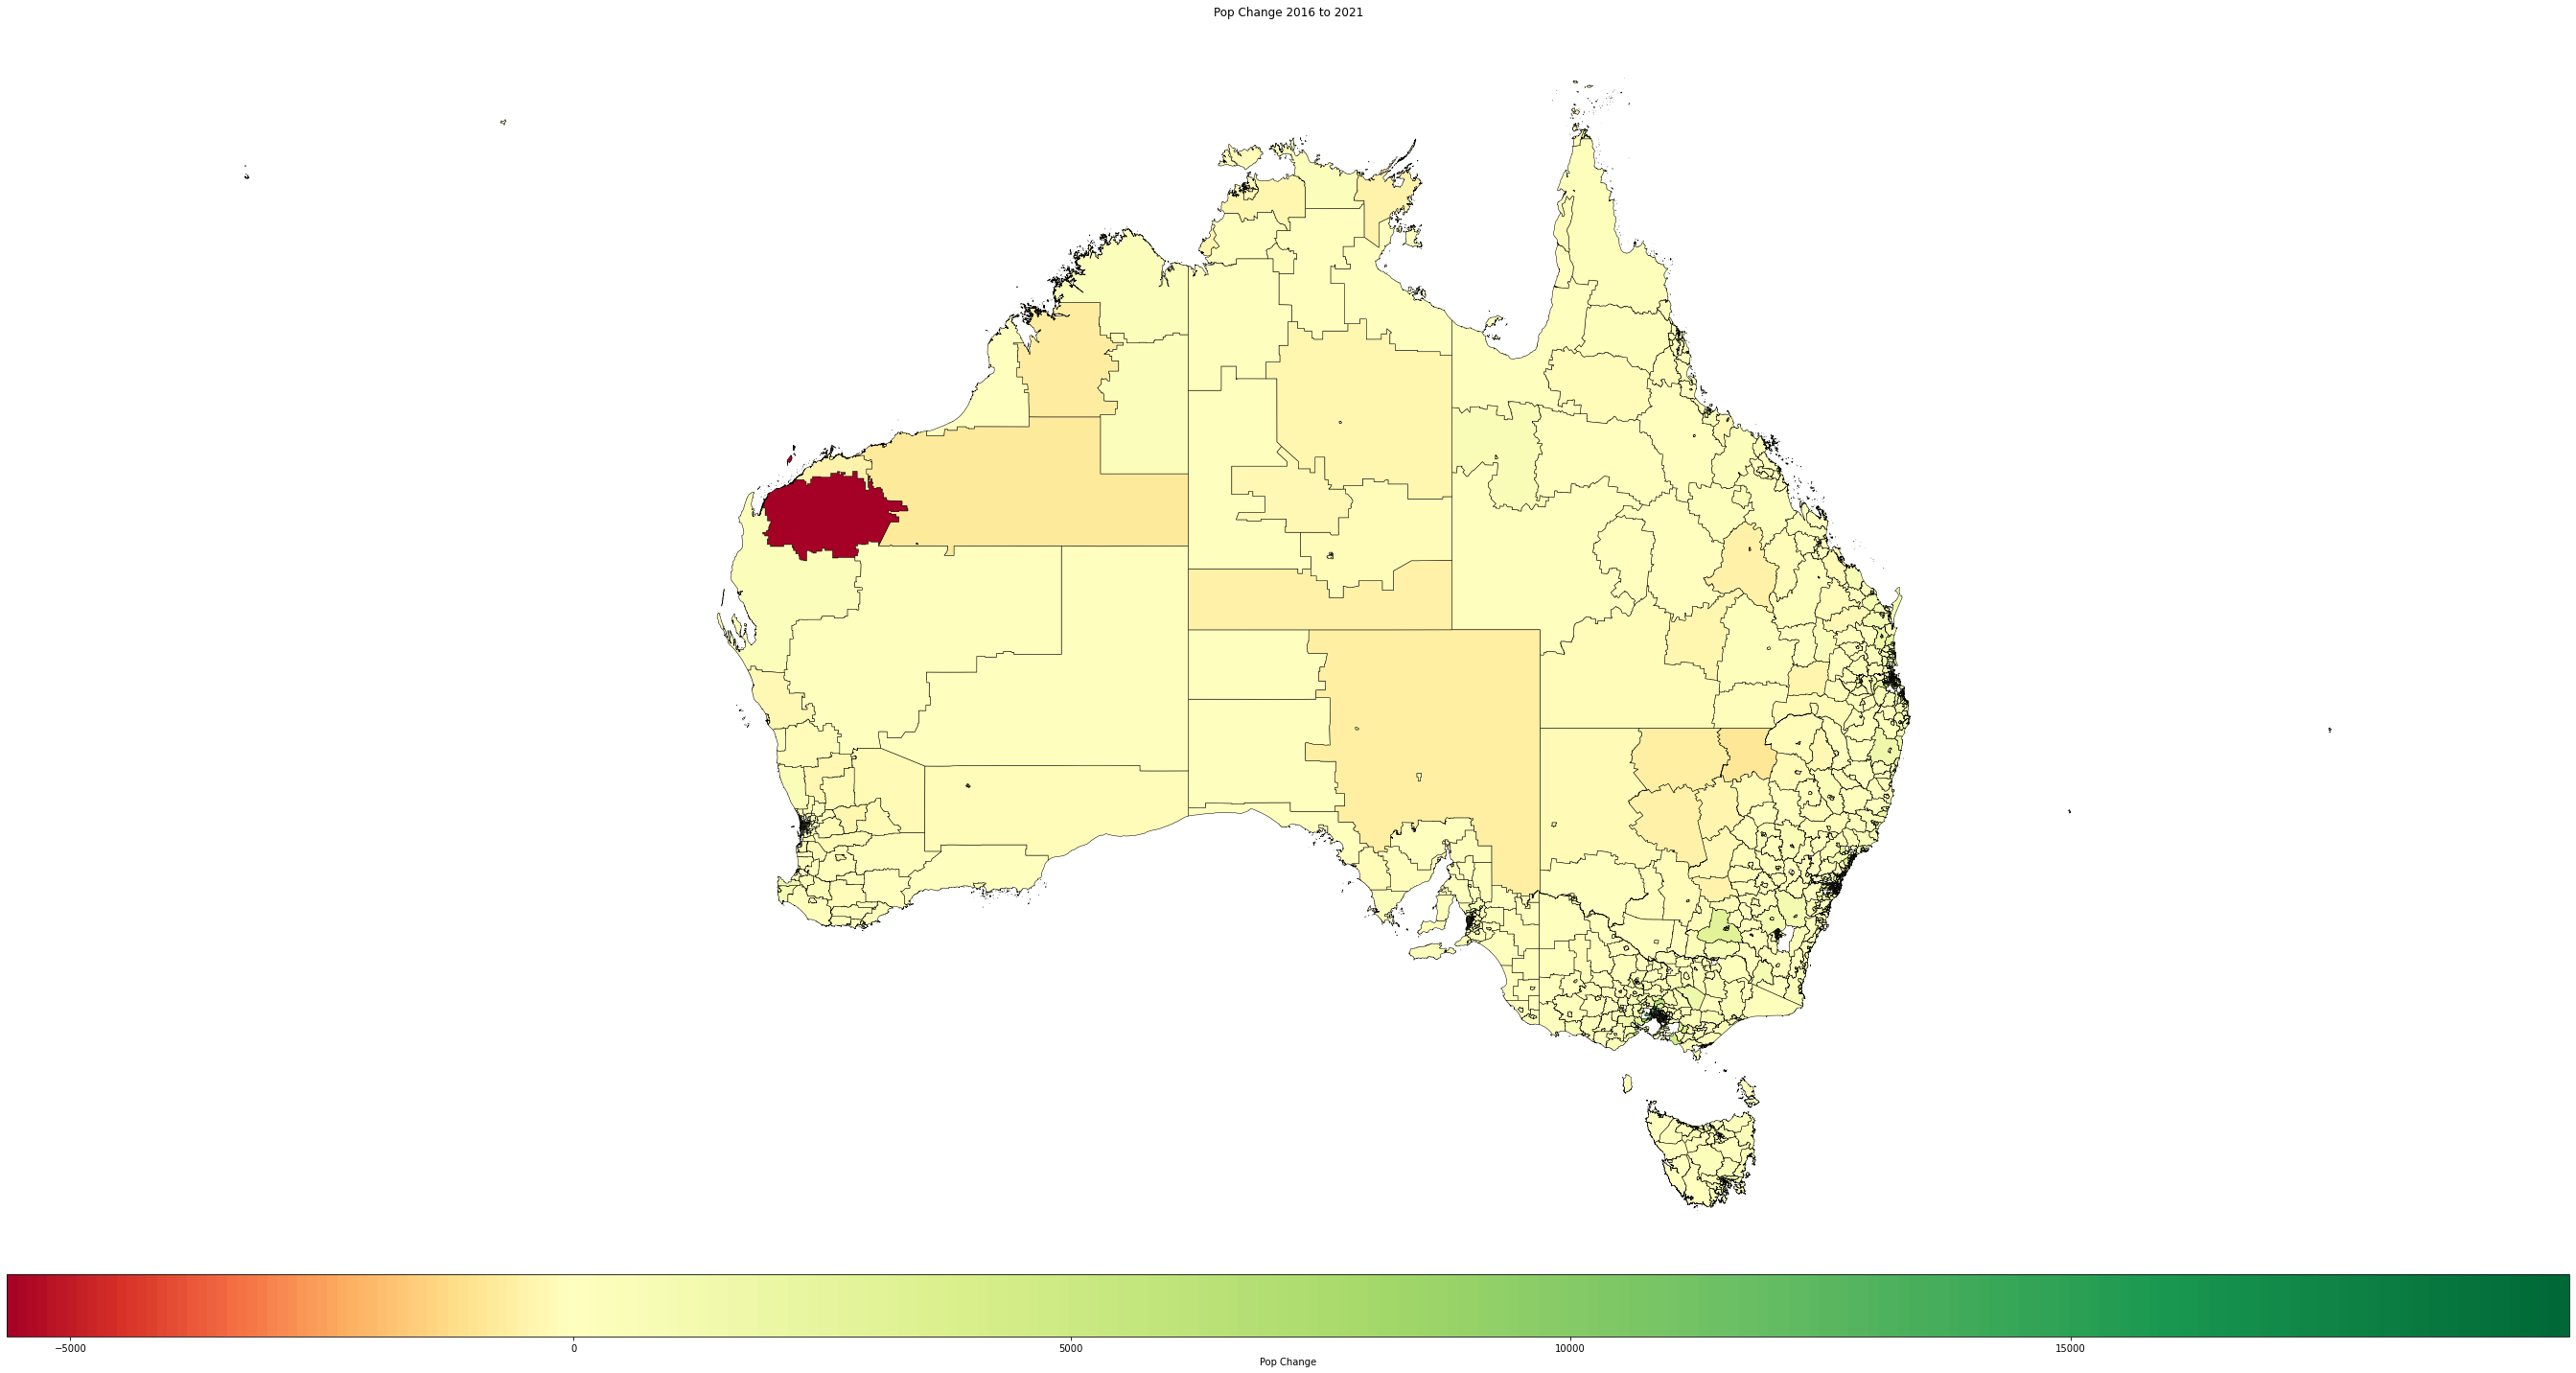

In [22]:
# Plot a static choropleth using matplotlib functionality. Note because of the size you need to click on the image to zoom in.
tdf = df_merged.copy()

fig, ax = plt.subplots(1, figsize=(50,20))

# make the color bar be centered at zero
norm = TwoSlopeNorm(vcenter=0, vmin = tdf.Change_2016_to_2021.min(), vmax = tdf.Change_2016_to_2021.max())

# legend scaling so it is the same size as the map
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

# Plot 
tdf.plot(column='Change_2016_to_2021', cmap='RdYlGn',
         ax=ax, cax=cax, norm = norm, legend=True,
         legend_kwds={'label': "Pop Change", 'orientation' : 'horizontal'},
         edgecolor='black', linewidth=0.5)

# Plot Aesthetics
ax.set_title('Pop Change 2016 to 2021')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.tight_layout()
plt.show()

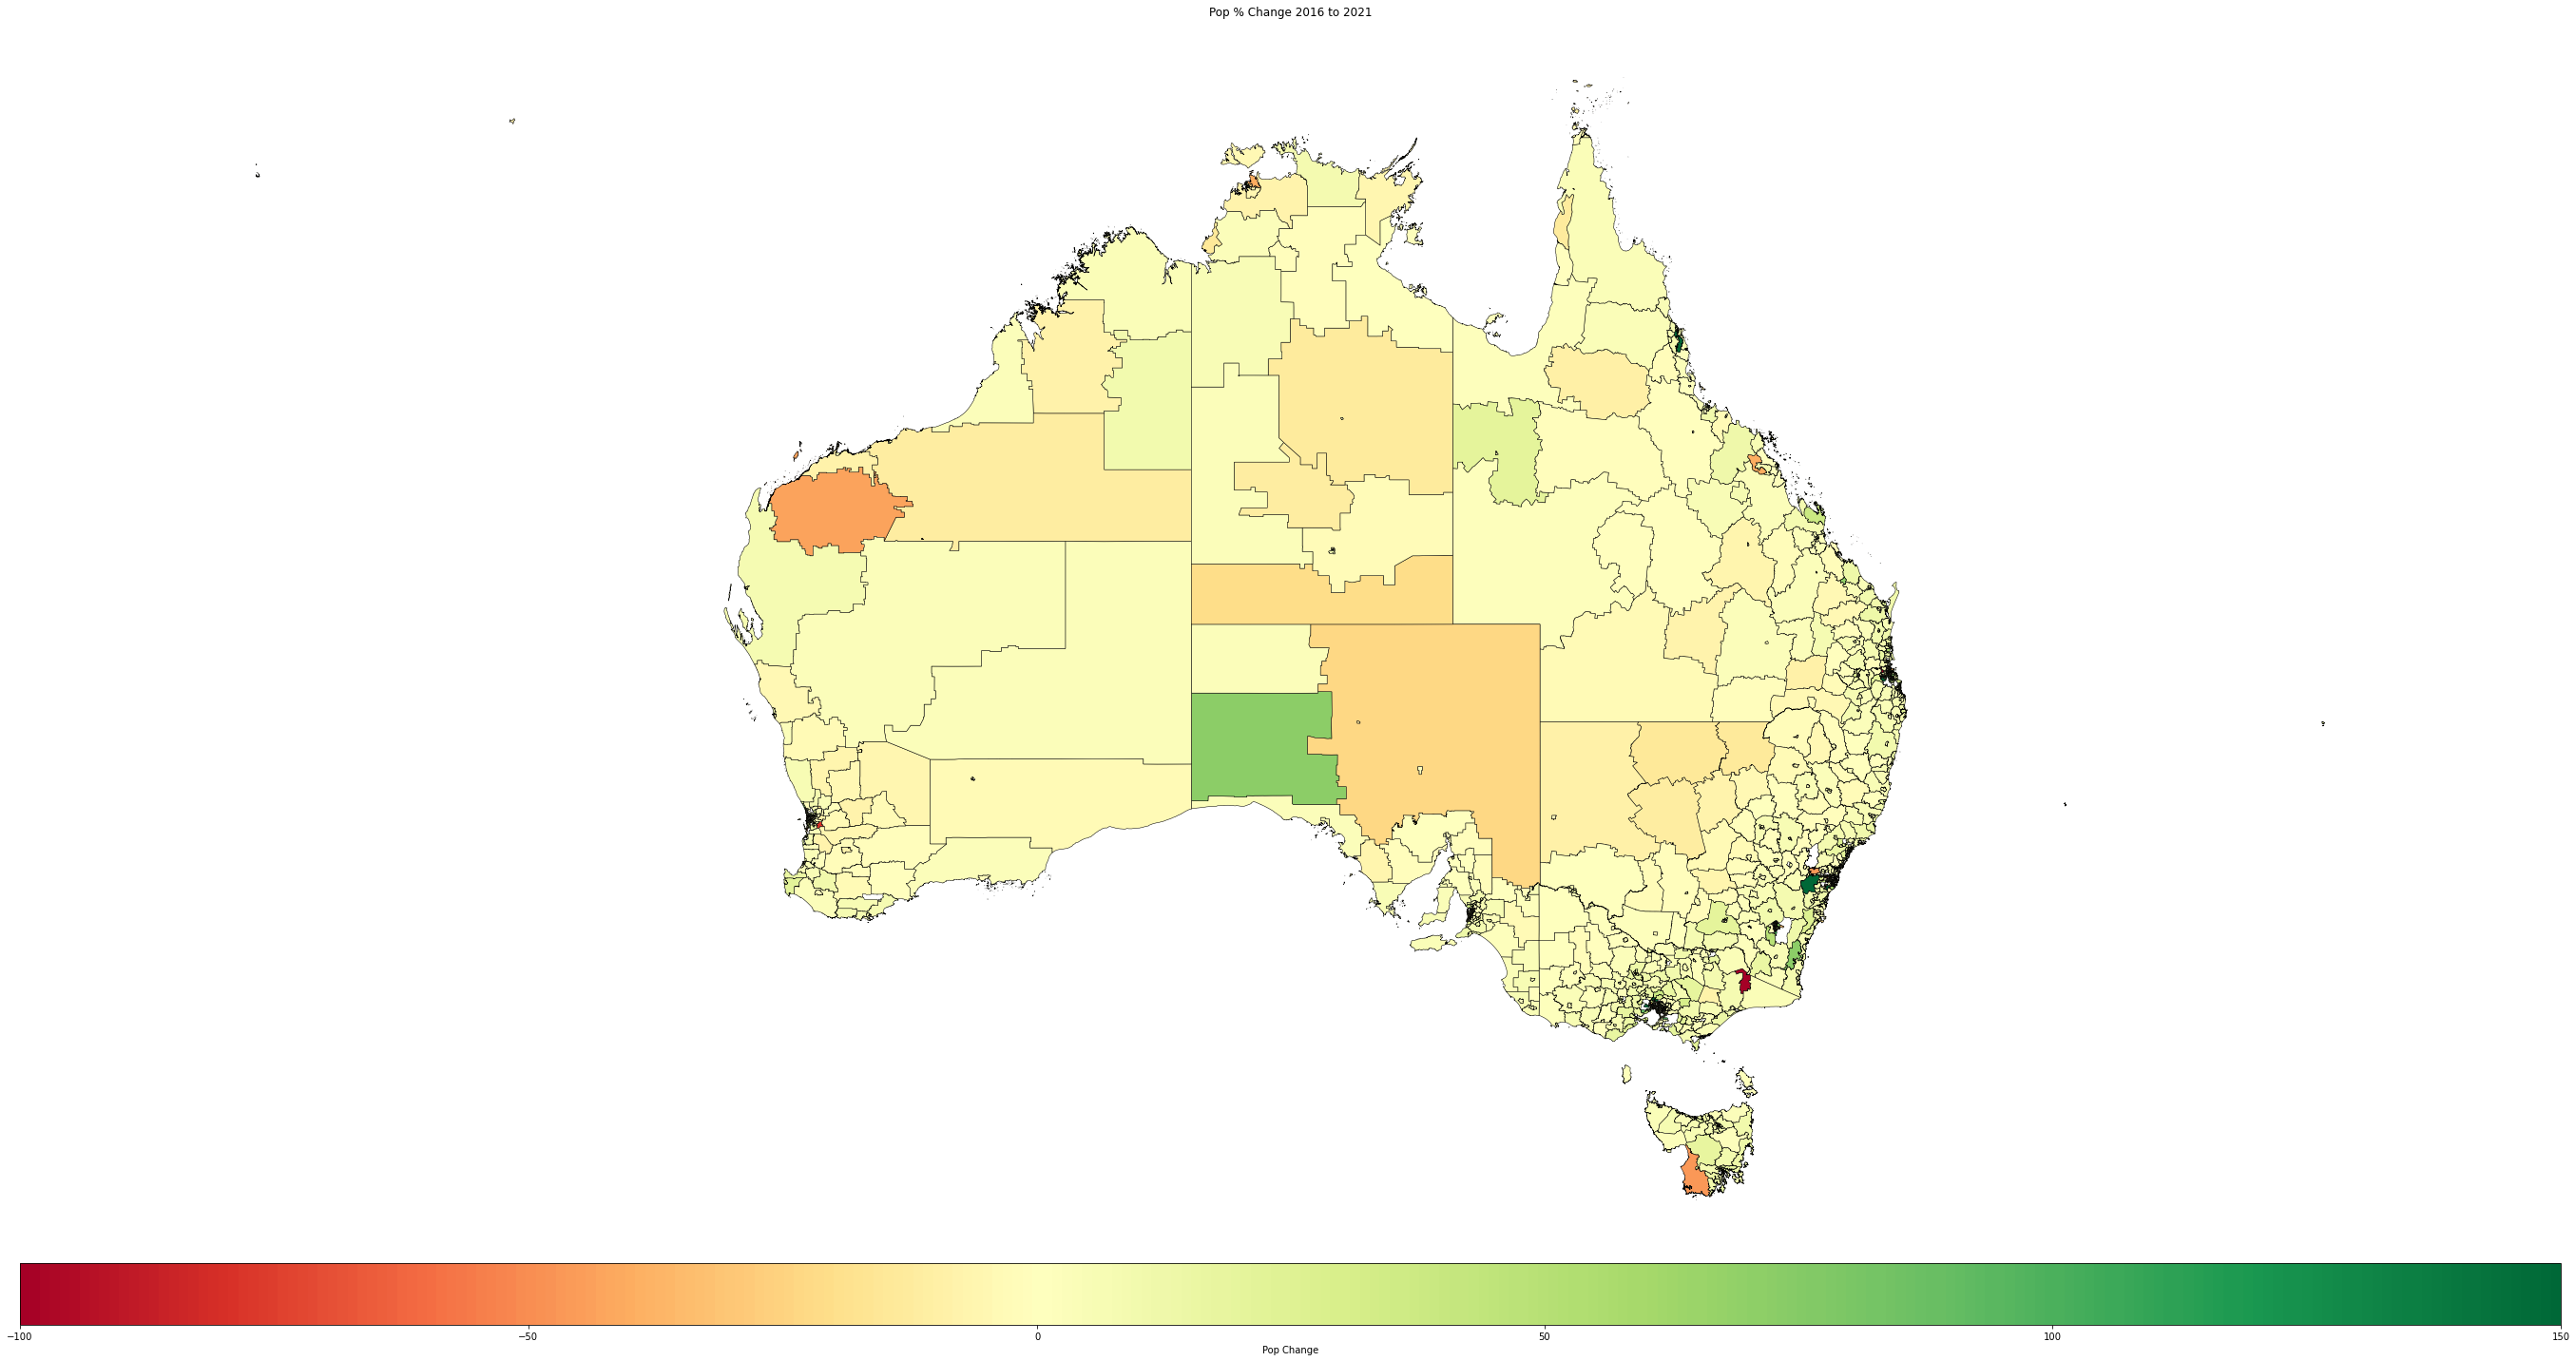

In [23]:
# Plot a static choropleth using matplotlib functionality. Note because of the size you need to click on the image to zoom in.
tdf = df_merged.copy()
tdf['Change_pc'] = tdf['Change_pc']*100

fig, ax = plt.subplots(1, figsize=(50,20))

# make the color bar be centered at zero, manually crafted vmax at 150% based on above head query (step 20)
norm = TwoSlopeNorm(vcenter=0, vmin = tdf['Change_pc'].min(), vmax = 150)

# legend scaling so it is the same size as the map
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

# Plot 
tdf.plot(column='Change_pc', cmap='RdYlGn',
         ax=ax, cax=cax, norm = norm, legend=True,
         legend_kwds={'label': "Pop Change", 'orientation' : 'horizontal'},
         edgecolor='black', linewidth=0.5)

# Plot Aesthetics
ax.set_title('Pop % Change 2016 to 2021')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.tight_layout()
plt.show()

In [16]:
tdf['Change_pc'].max()

inf

### To do:
- Implement the "urban"/"regional" split previously used in Solar Panel analysis (https://github.com/blkemp/ABS-Region-Data)
- Implement lookups to categorise SA2s by state
- Run charts for States excluding city
- Run charts for each city
- [x] Have fun